In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [3]:
r = 0.1; sig = 0.2                
S0 = 100; X0 = np.log(S0)          
K = 100; Texpir = 1

In [4]:
Nspace = 3000   # M space steps
Ntime = 2000    # N time steps   

S_max = 3*float(K)                
S_min = float(K)/3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

In [5]:
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization
Payoff = np.maximum(np.exp(x)-K,0)          # Call payoff

In [6]:
V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )  # boundary condition
V[0,:] = 0                         # boundary condition

In [8]:
# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx*dx

a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()

In [9]:
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )

In [10]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

13.269144076030782


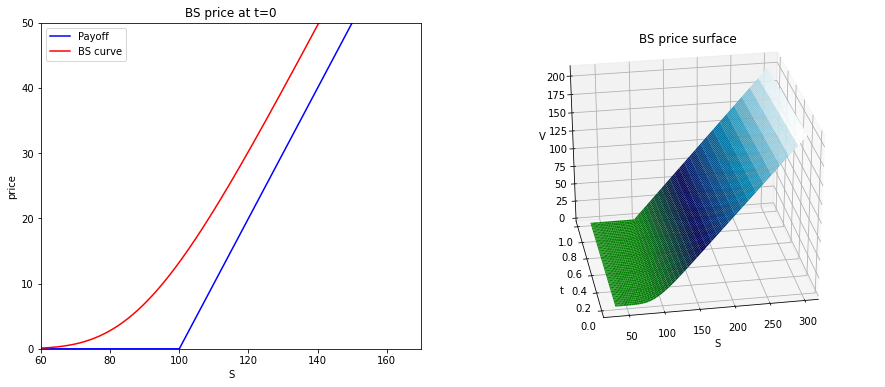

In [11]:
S = np.exp(x)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="BS curve")
ax1.set_xlim(60,170); ax1.set_ylim(0,50)
ax1.set_xlabel("S"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()